In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

print('資料集大小: ', user_movie_ratings.shape)
user_movie_ratings.iloc[:6, :10]

資料集大小:  (610, 9719)


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#輸入資料集、電影類型，回傳平均評分的分數
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1).reindex(avg_genre_votes_per_user.index)
        
    genre_ratings.columns = column_names
    return genre_ratings

In [7]:
genres_lst =[]
for i in movies['genres']:
    for x in i.split("|"):
        if x not in genres_lst:
            genres_lst.append(x)

In [8]:
genres_lst

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'War',
 'Musical',
 'Documentary',
 'IMAX',
 'Western',
 'Film-Noir',
 '(no genres listed)']

In [9]:
##愛情片 和 恐怖片
genre_ratings = get_genre_ratings(ratings, movies, ['Romance','Horror'], ['avg_romance_rating', 'avg_Horror_rating'])
genre_ratings

,avg_romance_rating,avg_Horror_rating
userId,,
1,4.31,3.47
2,4.50,3.00
3,0.50,4.69
4,3.38,4.25
5,3.09,3.00
...,...,...
606,3.74,3.35
607,3.52,4.11
608,2.89,3.32


In [10]:
genre_ratings[['avg_romance_rating','avg_Horror_rating']].values

array([[4.31, 3.47],
       [4.5 , 3.  ],
       [0.5 , 4.69],
       ...,
       [2.89, 3.32],
       [3.2 , 3.5 ],
       [3.73, 3.51]])

In [11]:
#將電影性值分割
genres = movies['genres'].str.split("|",expand= True)
num_genres = pd.DataFrame(np.array(genres).reshape(97420 ,1))
pd.value_counts(num_genres[0])

Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: 0, dtype: int64

C:\Users\emily\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


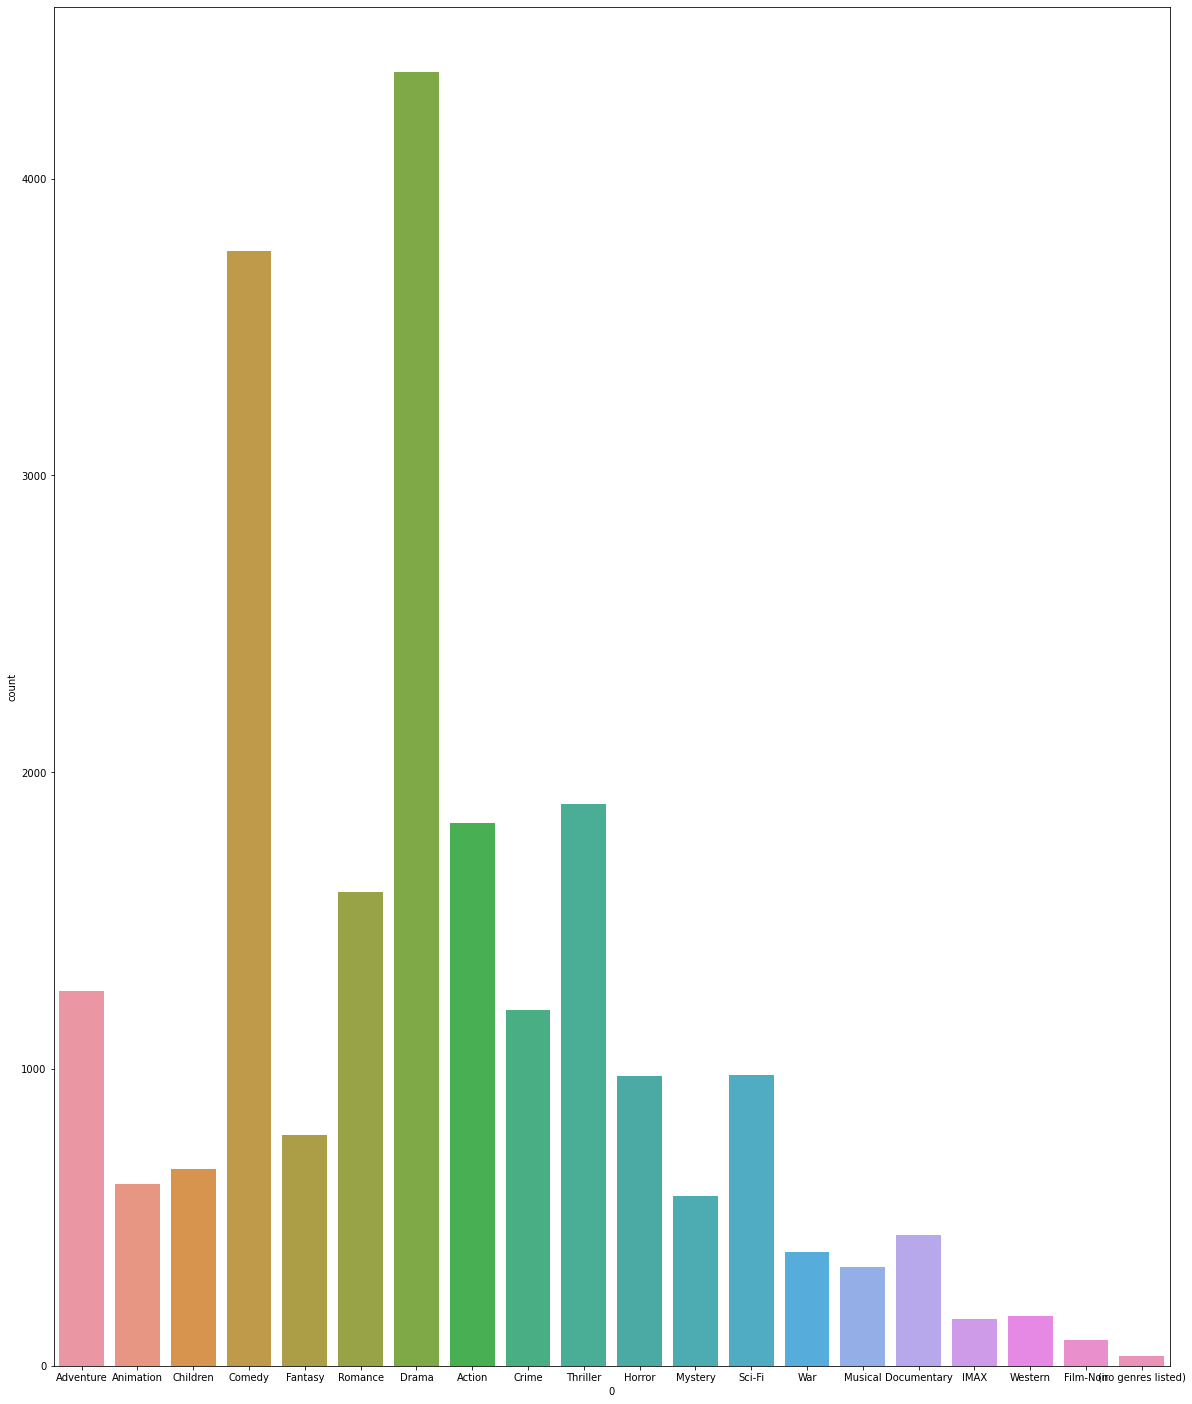

In [12]:
plt.figure(figsize=(20,25))
sns.countplot(num_genres[0],)
plt.show()

In [13]:
#Function to get the biased dataset 
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2): 
    biased_dataset = genre_ratings[((genre_ratings['avg_Horror_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_romance_rating'] > score_limit_2)) | ((genre_ratings['avg_romance_rating'] < score_limit_1) & (genre_ratings['avg_Horror_rating'] > score_limit_2))] 
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]]) 
    biased_dataset = pd.DataFrame(biased_dataset.to_records()) 
    return biased_dataset 
# Bias the dataset 
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5) 
# Printing the resulting number of records & the head of the dataset 
print( "Number of records: ", len(biased_dataset)) 
biased_dataset.head()



Number of records:  175


,userId,avg_romance_rating,avg_Horror_rating
0,3,0.50,4.69
1,5,3.09,3.00
2,7,2.65,4.00
3,9,3.17,1.80
4,10,3.33,1.75


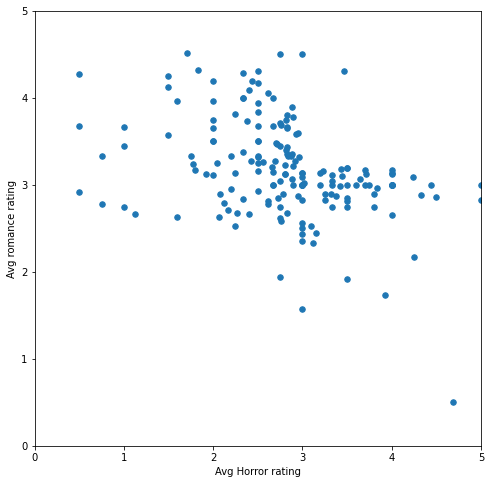

In [14]:
#將上述162筆資料進行視覺化分析
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)
# Plot the scatterplot
draw_scatterplot(biased_dataset['avg_Horror_rating'],'Avg Horror rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

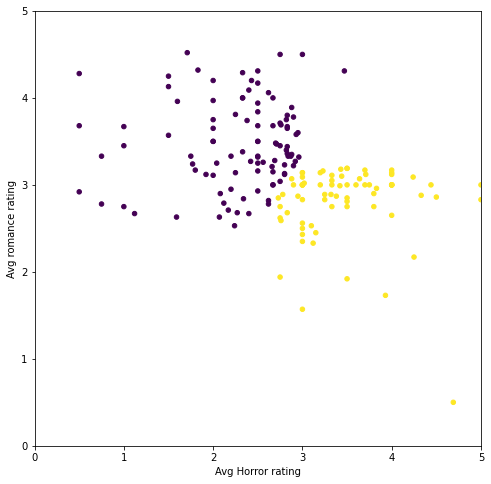

In [15]:
#進行分群
from sklearn.cluster import KMeans

#抓取訓練資料集
X = biased_dataset[['avg_Horror_rating','avg_romance_rating']].values

#K值為2
kmeans_1 = KMeans(n_clusters=2)
predictions = kmeans_1.fit_predict(X)

#畫圖
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg Horror rating')
    ax.set_ylabel('Avg romance rating')
    
    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_Horror_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)
    
# Plot
draw_clusters(biased_dataset, predictions)

In [16]:
#分群畫圖函數
def fit_plot_kmean_model(n_clusters, X):
    plt.xticks(())
    plt.yticks(())

    #設定k值
    kmean = KMeans(n_clusters=n_clusters)
    kmean.fit_predict(X)

    labels = kmean.labels_
    centers = kmean.cluster_centers_
    markers = ['o', '^', '*', 's']
    colors = ['r', 'b', 'y', 'k']

    #調用sklearn內建的模型分數
    #該值越大越好
    score = kmean.score(X)
    plt.title("k={}, score={}".format(n_clusters, (int)(score)))

    #畫圖
    for c in range(n_clusters):
        cluster = X[labels == c]
        plt.scatter(cluster[:, 0], cluster[:, 1], 
                    marker=markers[c], s=20, c=colors[c])
    #畫質心
    plt.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=0.9, s=300)
    for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, s=50, c=colors[i])

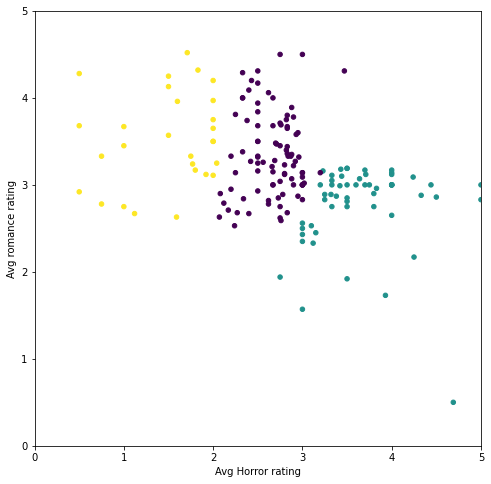

In [17]:
#K值為3
kmeans_2 = KMeans(n_clusters=3)
predictions_2 = kmeans_2.fit_predict(X)

draw_clusters(biased_dataset, predictions_2)



#紫色 喜歡恐怖片大於愛情片
#綠色 喜歡愛情片大於恐怖片
#黃色 喜歡恐怖跟愛情片

In [18]:
#分群畫圖函數
def fit_plot_kmean_model(n_clusters, X):
    plt.xticks(())
    plt.yticks(())

    #設定k值
    kmean = KMeans(n_clusters=n_clusters)
    kmean.fit_predict(X)

    labels = kmean.labels_
    centers = kmean.cluster_centers_
    markers = ['o', '^', '*', 's']
    colors = ['r', 'b', 'y', 'k']

    #調用sklearn內建的模型分數
    #該值越大越好
    score = kmean.score(X)
    plt.title("k={}, score={}".format(n_clusters, (int)(score)))

    #畫圖
    for c in range(n_clusters):
        cluster = X[labels == c]
        plt.scatter(cluster[:, 0], cluster[:, 1], 
                    marker=markers[c], s=20, c=colors[c])
    #畫質心
    plt.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=0.9, s=300)
    for i, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker='$%d$' % i, s=50, c=colors[i])

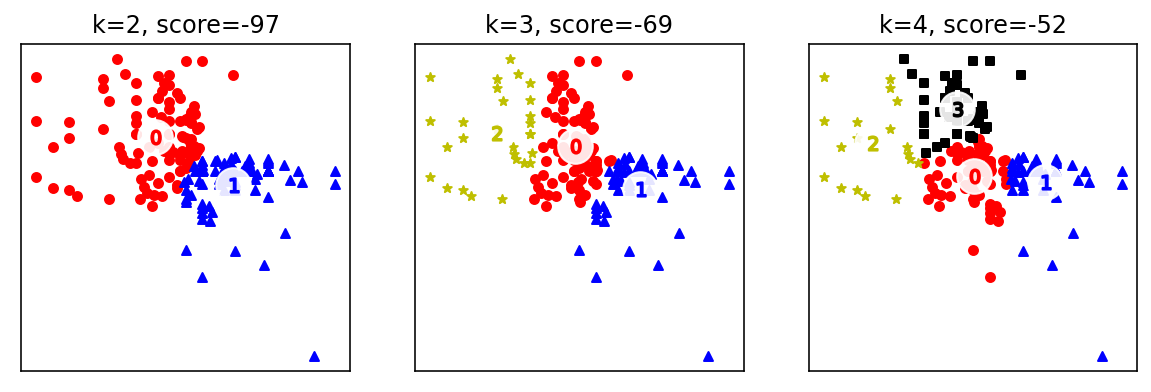

In [19]:
from sklearn.cluster import KMeans

#特別定義K值
n_clusters = [2, 3, 4]

plt.figure(figsize=(10, 3), dpi=144)
for i, c in enumerate(n_clusters):
    plt.subplot(1, 3, i + 1)
    fit_plot_kmean_model(c, X)
    

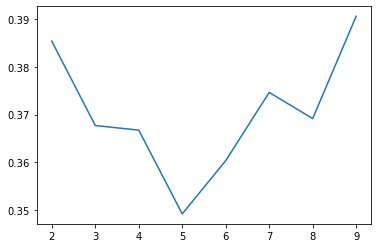

In [20]:
#透過輪廓係數
from sklearn.metrics import silhouette_score

silhouette_avg = []
for i in range(2,10):
    kmeans_fit = KMeans(n_clusters = i).fit(X)
    silhouette_avg.append(silhouette_score(X, kmeans_fit.labels_))
    
plt.plot(range(2,10), silhouette_avg)

In [21]:
def OutputExcel(biased_dataset, predictions_2):
    df_inner = biased_dataset.merge(pd.DataFrame(predictions_2, columns=['分類']), how='inner', left_index=True, right_index=True)
    df_inner.sort_values(by=['分類']).to_csv("homework_K.csv",index=False)
    print( '成功產出homework_K.csv' )

In [22]:
OutputExcel(biased_dataset, predictions_2)

成功產出homework_K.csv
